<a href="https://colab.research.google.com/github/kretchmar/CS339_2023/blob/main/Classification_2D_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Example

Matt Kretchmar <p>
January 2023 <p>

In this notebook we load a simple 2D dataset that represents samples in two classes.  We build a classifier using the Naive Bayes classification algorithm.
We do this in two ways:
1. Using the built-in scikit learning toolkit
2. Hand-crafting our own Naive Bayes code from python/numpy

See also the Classification_2D_LinearSVM.ipynb for an example of the linear
support vector machine on the same dataset.  



In [ ]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


## Read 2D Data

Read the 2D dataset, print it, plot it


In [ ]:
# You will need to obtain the data2D.csv file and then put it in your google drive.
# Be sure to change the path after "My Drive" to your own file structure in your own google drive.

from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/My Drive/cs339/Notebooks/data2D.csv',sep='\t',index_col=0)

# disconnect the drive
drive.flush_and_unmount()




Mounted at /content/gdrive


           x1         x2  Class
0    5.163721   9.511413      0
1    7.638432   8.317251      0
2   11.663044   8.299338      0
3    7.870167   8.810545      0
4    4.774249  10.921027      0
..        ...        ...    ...
95  11.156722   8.764939      1
96  11.806759   9.939947      1
97  10.479419  10.904993      1
98  10.398550   9.800563      1
99  11.962008  11.199231      1

[250 rows x 3 columns]


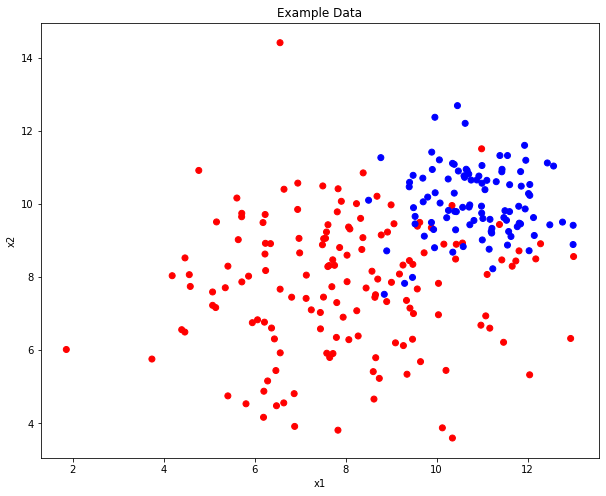

In [ ]:
# Let's print and plot the data so we can visualize it.
print(data)
colors = { 0:'red', 1:'blue'}
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(data.x1,data.x2,c=data.Class.map(colors))
plt.title('Example Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Testing and Training Sets
Divide Data into test set and training set.


In [ ]:
def buildTrainTestSet ( df, percent=0.2 ):
  '''
  The function takes a dataset and helps break it into a testing set
  and a training set.  
  PARAMETERS:
  df - a pandas dataframe with one column named "Class" which
  is the target output category.  
  The columns are attributes and the rows are samples.  

  percent - a percentage between 0 and 1 which indicates how
  much of the data should be used for the test set.  The
  remaining data is used for the training set.

  RETURN VALUE: dfTrain, dfTest
  The function returns two pandas dataframes which the same
  structure as the input dataframe.  The input dataframe is
  partitioned into a test set comprising "percent"% of the
  rows randomly selected from the original dataframe. The training
  set is the remaining 1-percent % of the data rows.  
  Note that the input dataframe is first sorted by the "label" 
  columns and the percentage is taken from each category (each
  unique label value).  That way the testing and training set
  each have approximately the same percentage of samples with
  each label value.  
  '''
  # initialize dfTest and dfTrain to None 
  dfTest = None
  dfTrain = None

  # find unique labels and sort dataset by labels
  vals = df.Class.unique()
  df2 = df.sort_values(by=['Class'])

  # for each label, we will select percent of the rows for testing, 
  # keep the rest for training
  for val in vals:
    # get subset of rows with this label val
    df3 = df2.loc[df2['Class'] == val]
    count = len(df3)
    # random permutation of all these row indices
    shuffle = np.random.permutation(count)
    # select set of indices for test set rows 
    # and training set rows
    testIndices = shuffle[:int(count*percent)]
    trainIndices = shuffle[int(count*percent):]

    testSetTemp = df3.iloc[testIndices]
    trainSetTemp = df3.iloc[trainIndices]

    # append and build test and training sets
    if dfTest is None:
      dfTest = testSetTemp
      dfTrain = trainSetTemp
    else:
      dfTest = dfTest.append(testSetTemp)
      dfTrain = dfTrain.append(trainSetTemp)

  return dfTrain,dfTest



In [ ]:

trainSet,testSet = buildTrainTestSet(data,0.3)
print('Training Set\n',len(trainSet))
print(trainSet)
print('Testing Set \n',len(testSet))
print(testSet)

Training Set
 175
            x1         x2  Class
53    7.581077   9.235242      0
6     6.647412  10.406209      0
106   5.077270   7.594130      0
39    7.519161   9.052429      0
86   10.340042   9.960772      0
..         ...        ...    ...
78   10.351635  11.114884      1
52   10.256096  10.686361      1
12    9.528228   9.457146      1
33   11.440429  10.951730      1
86   11.774994   9.381326      1

[175 rows x 3 columns]
Testing Set 
 75
            x1         x2  Class
143   7.807076   7.303473      0
149   8.691426  10.214538      0
42    8.644891   7.448074      0
37   10.128485   3.874587      0
87    4.468157   6.496922      0
..         ...        ...    ...
71    9.298271   7.829462      1
21   11.559836  11.328739      1
1     9.894635  11.422076      1
27   11.105903  10.649935      1
37    9.529253   9.662515      1

[75 rows x 3 columns]


## Naive Bayes
#### (using sklearn toolkit)

In this situation we attempt obtain a sample and measure its attributes represented by value $x$.   We want to compute the probability that this sample comes from each possible class.  The class with the highest probability (here denoted as $C_i$) is the output of the classifier.  

This algorithm works with Bayes Formula:

$$
P(C_i | x) = \frac{ P(x | C_i) \cdot P(C_i) }{ P(x) }
$$

where  $C_i$ is the event that the sample is a member of category $i$ and $x$ is the event that we obtain the sample with the given attributes.  Each term in Bayes Formula has an important role.   

- $P(C_i)$ is called the *prior*.  This is the prior probability of the next sample belonging to class $C_i$ *before* we know the attribute $x$.   The best way to compute this is to select the $C_i$ with the largest number of samples -- the fraction of all samples with category $C_i$ is the Bayesian prior $P(C_i)$.  


- $P(x)$ is called the *evidence*.  It is the probability of observing $x$ considering all possible categories.   

- $P(x|C_i)$ is called the *likelihood*.  This is the probability of observing attribute $x$ given that we know the sample comes from category $C_i$.   

- $P(C_i|x)$ is the Bayesian *posterior*.  This is the probability that, given we observe sample $x$, the sample comes from category $C_i$.  This is what we are trying to compute for each category.  


We can compute two of the three terms on the RHS by

$$
P(C_i) = \frac{\mathrm{number\ samples\ from\ } C_i}{ \mathrm{total\ number\ samples}} 
$$

 <p>
 <p>
 <p>

$$
P(x) = \sum_{i} P(x|C_i) \cdot P(C_i)
$$

The last term, the *Bayesian likelihood* comes from a model that maps observations from categories to probabilities.  Often the data will be distributed by or closely by a normal distribution.  Thus we can fit a normal distribution to the data by finding the mean $\mu$ and the standard deviation $\sigma$ of the data from that category and then computing the likelihood probability by

$$
P(x|C_i) = \frac{1}{\sqrt{2 \pi} \sigma_i} e^{-\frac{1}{2} \left( \frac{x-\mu_i}{\sigma_i}\right)^2}
$$

If $x$ is a vector (if dimension is greater than 1) then we must use the vector form of gaussian distribution with 

$$
P(x|C_i) = \frac{1}{ (2 \pi)^{\frac{d}{2}} | \Sigma_i |^{\frac{1}{2}} }
e^{-\frac{1}{2} (x-u_i)^t \cdot \Sigma_i^{-1} \cdot (x-\mu_i)}
$$

where $x$ is a column vector of dimension $d$, $\mu_i$ is the column vector of means, $\Sigma_i$ is the $d \times d$ covariance matrix from the data and $| \Sigma |$ and $\Sigma^{-1}$ are the determinant and inverse respectively.  We let $x^t$ denote the transpose of vector $x$. 


In [ ]:
# We use the SVM package from sklearn toolkit
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Note that X must be in the form of (n,d) where n is the number of 
# samples and d is the number of attributes (dimensionality)
# Here we have n = | trainSet |
# d = 2 since there are 2 attributes for each x (2D data)
X = trainSet.iloc[:,:2].to_numpy()
Y = trainSet.iloc[:,2].to_numpy()

# fit the training data
clf.fit(X,Y)



GaussianNB()

### Analyze Results

Let us plot the decision boundary and also compute the classification rate

In [ ]:
# Extract x test values and y labels from test set
Xtest = testSet.iloc[:,:2].to_numpy()
ytest = testSet.iloc[:,2].to_numpy().astype(int)

# Use model to predict category
z = clf.predict(Xtest).astype(int)

# Compare ytest and z to count errors
n = len(ytest)
count_incorrect = np.sum(z != ytest)
accuracy = (n-count_incorrect) / n

# Report results
print("Num Test Samples: {0:d}".format(n))
print("Num Errors:       {0:d}".format(count_incorrect))
print("Accuracy:         {0:4.2f}".format(accuracy))



Num Test Samples: 75
Num Errors:       10
Accuracy:         0.87


In [ ]:
print("Test Target Categories")
print(ytest)
print("SVM Computed Categories")
print(z)


Test Target Categories
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
SVM Computed Categories
[0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1]


#### Display Decision Surface
We display the decision surface by computing a 100x100 array of points over the characterstic space.  Each point is classified by the SVM so we can visualize where the decision boundary exists.  

In [ ]:
resolution = 100
t = np.linspace(0,14,resolution)
xx = np.zeros((resolution*resolution,2))

for i in range(len(t)):
  for j in range(len(t)):
    xx[i*resolution+j][0] = t[i]
    xx[i*resolution+j][1] = t[j]

zz = clf.predict(xx)


In [ ]:
  yy = np.reshape(zz,(resolution*resolution,1)).astype(int)
  total = np.concatenate((xx,yy),axis=1)
  #total = np.transpose(total)
  print(total.shape)
  grid = pd.DataFrame(data=total,columns=['x1', 'x2', 'Class'])
  print(grid)


(10000, 3)
        x1         x2  Class
0      0.0   0.000000    0.0
1      0.0   0.141414    0.0
2      0.0   0.282828    0.0
3      0.0   0.424242    0.0
4      0.0   0.565657    0.0
...    ...        ...    ...
9995  14.0  13.434343    0.0
9996  14.0  13.575758    0.0
9997  14.0  13.717172    0.0
9998  14.0  13.858586    0.0
9999  14.0  14.000000    0.0

[10000 rows x 3 columns]


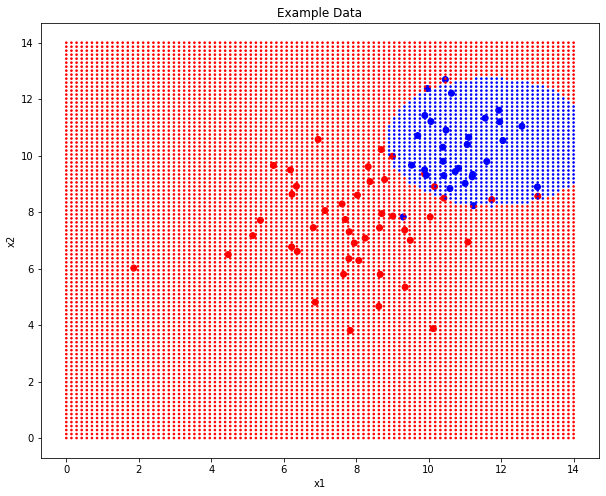

In [ ]:
colors = { 0:'red', 1:'blue'}
fig,ax = plt.subplots(figsize=(10,8))
# plot test set points
ax.scatter(testSet.x1,testSet.x2,c=testSet.Class.map(colors))
# plot grid points so we can see decision surface
ax.scatter(grid.x1,grid.x2,c=grid.Class.map(colors),s=10,marker='.')

plt.title('Example Data')
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()


## Naive Bayes
### (by hand code)
Now we repeat the Naive Bayes classifier but use hand-written code instead of the sklearn toolkit. 

### Parameter Estimation
n = sample size <p>
$\mu$ = sample mean <p>
$\Sigma$ = sample covariance matrix<p>


The first step is to take the samples from the training set and split them up by category.  For each category we must compute the sample size, the sample mean, and the sample covariance matrix.  Notice the mean is now a vector instead of a point (since the data is in 2D space) and the covariance matrix is a 2x2 matrix instead of the single point which was the standard deviation. 

In [ ]:

# Category 0
X = trainSet[trainSet.Class==0].iloc[:,:2].to_numpy()
n0 = len(trainSet[trainSet.Class==0])
mu0 = X.mean(axis=0)
Sigma0 = np.cov(X.transpose())
print("n0 =",n0)
print("mu0 =",mu0)
print("Sigma0 =",Sigma0)

# Category 1
X = trainSet[trainSet.Class==1].iloc[:,:2].to_numpy()
n1 = len(trainSet[trainSet.Class==1])
mu1 = X.mean(axis=0)
Sigma1 = np.cov(X.transpose())
print("n1 =",n1)
print("mu1 =",mu1)
print("Sigma1 =",Sigma1)


n0 = 105
mu0 = [7.96498892 7.85635863]
Sigma0 = [[4.38523339 0.10070756]
 [0.10070756 3.45295921]]
n1 = 70
mu1 = [10.85911478  9.98930056]
Sigma1 = [[ 1.03296259 -0.00241609]
 [-0.00241609  0.66517975]]


#### Bayesian Functions
Functions to compute
- Priors
- Likelihoods
- Evidence
- Posterior

Here we write our own code to compute the four terms in Bayes equation.  We make use of the built-in scipy computation for the probability density function for multivariate normal distribution.  

In [ ]:
import scipy.stats

def compute_prior (ns,cat):
  '''
  ns is a list of sample sizes
  Computes ni/sum(n)
  where ni is the index in ns specified by cat
  '''
  return ns[cat] / ns.sum()

def compute_likelihood (x,mu,sig):
  '''
  Computes Bayesian Likelihood
  x = d dimensional input
  mu = d dimensional mean vector
  sig = dxd covariance matrix
  Note that mu and sig are category dependant
  '''
  return scipy.stats.multivariate_normal(mu,sig).pdf(x)

def compute_evidence (x, mus, sigs,priors):
  '''
  Compute Bayesian evidence where
  x is a d-dimensional vector
  mus is a M vector of d dimensional vectors
  M is the number of different categories
  Sig is a M vector of dxd covariance matrices

  priors is a M vector of prior probabilities
  '''
  total = 0
  for i in range(len(mus)):
    total += compute_likelihood(x,mus[i],sigs[i]) * priors[i]

  return total

def compute_posterior (x,ns,mus,sigs):
  '''
  Computes the Bayesian Postieriors for each category
  x is a d-dimensional vector
  mus is a M vector of d dimensional vectors
  M is the number of different categories
  Sig is a M vector of dxd covariance matrices

  Returns a M-dimensional numpy array of probabilities for each category
  '''
  priors = np.zeros((len(mus),1))
  for c in range(len(mus)):
    priors[c] = compute_prior(ns,c)

  evidence = compute_evidence(x,mus,sigs,priors)
  posteriors = np.zeros(len(mus))

  for c in range(len(mus)):
    likelihood = compute_likelihood(x,mus[c],sigs[c])
    posteriors[c] = likelihood * priors[c] / evidence

  return posteriors




In [ ]:
# Some test calls

#Priors
print("Testing Prior\n")
ns = np.array([n0, n1])
print(n)
prior0 = compute_prior(ns,0)
print("Prior 0",prior0)
prior1 = compute_prior(ns,1)
print("Prior 1",prior1)
priors = np.array([prior0, prior1])

#Likelihoods
print("\nTesting Likelihood\n")

# we make up four points
# point 0 is right in the middle of category 0
# point 1 is right in the middle of category 1
# point 2 is near the boundary but just inside the cat 1 space
# point 3 is outside both categories, but is likely to get claimed by cat 0
testx = np.array([[8,8],
                  [12,11],
                  [10,10],
                  [8,12]])

for xx in testx:
  like0 = compute_likelihood(xx,mu0,Sigma0)
  like1 = compute_likelihood(xx,mu1,Sigma1)
  print("[{0:6.2f},{1:6.2f} ]:".format(xx[0],xx[1]))
  print("\tlike0:  {0:8.6f}".format(like0))
  print("\tlike1:  {0:8.6f}".format(like1))

# test evidence for each point
print("\nTesting Evidence\n")
  
mus = np.array([mu0, mu1])
Sigmas = np.array([Sigma0, Sigma1])
for xx in testx:
  evidence = compute_evidence(xx,mus,Sigmas,priors)  
  print("[{0:6.2f},{1:6.2f} ]:".format(xx[0],xx[1]))
  print("\tevidence = {0:8.6f}".format(evidence))

# test posterior probabilities for each point
print('\nTesting Posterior')
for xx in testx:
  posteriors = compute_posterior(xx,ns,mus,Sigmas)
  print("[{0:6.2f},{1:6.2f} ]:".format(xx[0],xx[1]))
  print("\tposterior 0 = {0:8.6f}".format(posteriors[0]))
  print("\tposterior 1 = {0:8.6f}".format(posteriors[1]))


  


Testing Prior

[105  70]
Prior 0 0.6
Prior 1 0.4

Testing Likelihood

[  8.00,  8.00 ]:
	like0:  0.040788
	like1:  0.000184
[ 12.00, 11.00 ]:
	like0:  0.001659
	like1:  0.047255
[ 10.00, 10.00 ]:
	like0:  0.013493
	like1:  0.134316
[  8.00, 12.00 ]:
	like0:  0.003402
	like1:  0.000179

Testing Evidence

[  8.00,  8.00 ]:
	evidence = 0.024546
[ 12.00, 11.00 ]:
	evidence = 0.019898
[ 10.00, 10.00 ]:
	evidence = 0.061822
[  8.00, 12.00 ]:
	evidence = 0.002113

Testing Posterior
[  8.00,  8.00 ]:
	posterior 0 = 0.997005
	posterior 1 = 0.002995
[ 12.00, 11.00 ]:
	posterior 0 = 0.050030
	posterior 1 = 0.949970
[ 10.00, 10.00 ]:
	posterior 0 = 0.130952
	posterior 1 = 0.869048
[  8.00, 12.00 ]:
	posterior 0 = 0.966039
	posterior 1 = 0.033961


#### Compute Accuracy on Test Set

In [ ]:
y = np.zeros(len(testSet)).astype(int)
z = np.zeros(len(testSet)).astype(int)
for i in range(len(testSet)):
  xx = testSet.iloc[i,0:2].to_numpy()
  y[i] = testSet.iloc[i,2].astype(int)
  posts = compute_posterior(xx,ns,mus,Sigmas)
  if posts[0] >= 0.5:
    z[i] = 0
  else:
    z[i] = 1
  print("Test [{0:5.2f},{1:5.2f}] y={2:d}: z={3:d}".format(xx[0],xx[1],y[i],z[i]))


nn = len(y)
count_incorrect = np.sum(z != y)
accuracy = (nn-count_incorrect) / nn
print("Num Test Samples: {0:d}".format(nn))
print("Num Errors:       {0:d}".format(count_incorrect))
print("Accuracy:         {0:4.2f}".format(accuracy))




Test [ 7.81, 7.30] y=0: z=0
Test [ 8.69,10.21] y=0: z=0
Test [ 8.64, 7.45] y=0: z=0
Test [10.13, 3.87] y=0: z=0
Test [ 4.47, 6.50] y=0: z=0
Test [ 7.83, 3.81] y=0: z=0
Test [ 7.14, 8.06] y=0: z=0
Test [ 9.49, 7.00] y=0: z=0
Test [10.16, 8.90] y=0: z=1
Test [13.01, 8.56] y=0: z=1
Test [ 8.25, 7.08] y=0: z=0
Test [ 9.34, 7.36] y=0: z=0
Test [ 8.03, 8.60] y=0: z=0
Test [11.74, 8.44] y=0: z=1
Test [ 8.38, 9.08] y=0: z=0
Test [ 9.01, 7.86] y=0: z=0
Test [ 9.35, 5.34] y=0: z=0
Test [ 5.72, 9.65] y=0: z=0
Test [ 6.35, 8.92] y=0: z=0
Test [ 6.37, 6.61] y=0: z=0
Test [ 7.61, 8.29] y=0: z=0
Test [ 6.82, 7.45] y=0: z=0
Test [ 7.65, 5.80] y=0: z=0
Test [ 9.00, 9.98] y=0: z=1
Test [ 7.70, 7.74] y=0: z=0
Test [ 5.36, 7.71] y=0: z=0
Test [11.08, 6.94] y=0: z=0
Test [ 5.15, 7.17] y=0: z=0
Test [ 9.89, 9.35] y=0: z=1
Test [10.04, 7.83] y=0: z=0
Test [ 1.86, 6.02] y=0: z=0
Test [10.42, 8.49] y=0: z=1
Test [ 6.22, 6.77] y=0: z=0
Test [ 6.23, 8.63] y=0: z=0
Test [ 8.33, 9.61] y=0: z=0
Test [ 7.95, 6.90] y

#### Plot Boundary
Compute 100x100 grid of test points
and plot the results so we can visualize the classification boundary

In [ ]:
resolution = 100
t = np.linspace(0,14,resolution)
xx = np.zeros((resolution*resolution,2))
zz = np.zeros(resolution*resolution).astype(int)


for i in range(len(t)):
  for j in range(len(t)):
    xx[i*resolution+j][0] = t[i]
    xx[i*resolution+j][1] = t[j]
    posts = compute_posterior(xx[i*resolution+j],ns,mus,Sigmas)
    if posts[0] >= 0.5:
      zz[i*resolution+j] = 0
    else:
      zz[i*resolution+j] = 1




In [ ]:
yy = np.reshape(zz,(resolution*resolution,1)).astype(int)
total = np.concatenate((xx,yy),axis=1)
#total = np.transpose(total)
print(total.shape)
grid = pd.DataFrame(data=total,columns=['x1', 'x2', 'Class'])
#print(grid)


(10000, 3)


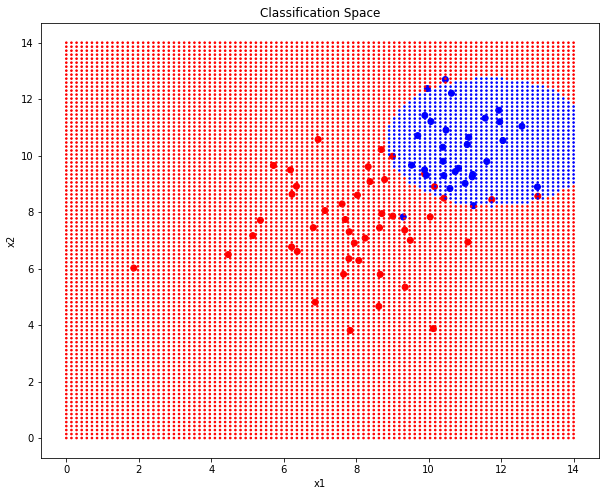

In [ ]:
colors = { 0:'red', 1:'blue'}
fig,ax = plt.subplots(figsize=(10,8))
# plot the test set points
ax.scatter(testSet.x1,testSet.x2,c=testSet.Class.map(colors))
# plot the grid points to visualize the boundary
ax.scatter(grid.x1,grid.x2,c=grid.Class.map(colors),s=10,marker='.')

plt.title('Classification Space')
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()
